In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score


In [20]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [21]:
print("Customers Dataset:\n", customers.head())
print("Products Dataset:\n", products.head())
print("Transactions Dataset:\n", transactions.head())

Customers Dataset:
   CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
Products Dataset:
   ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
Transactions Dataset:
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166  

          Quantity   TotalValue     Price_x     Price_y
count  1000.000000  1000.000000  1000.00000  1000.00000
mean      2.537000   689.995560   272.55407   272.55407
std       1.117981   493.144478   140.73639   140.73639
min       1.000000    16.080000    16.08000    16.08000
25%       2.000000   295.295000   147.95000   147.95000
50%       3.000000   588.880000   299.93000   299.93000
75%       4.000000  1011.660000   404.40000   404.40000
max       4.000000  1991.040000   497.76000   497.76000
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price_x            0
CustomerName       0
Region             0
SignupDate         0
ProductName        0
Category           0
Price_y            0
dtype: int64


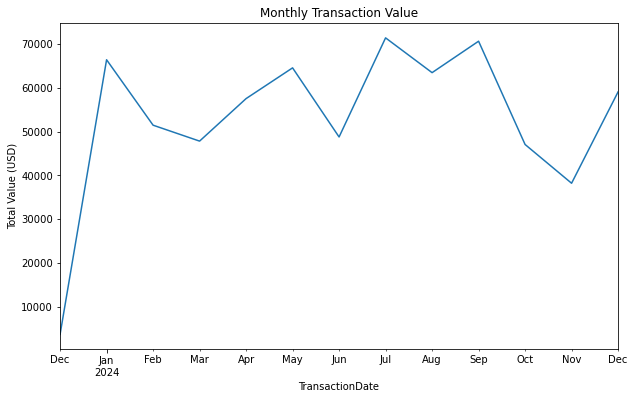

In [22]:
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')
print(merged_data.describe())
print(merged_data.isnull().sum())

merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
merged_data.set_index('TransactionDate', inplace=True)
merged_data['TotalValue'].resample('M').sum().plot(title='Monthly Transaction Value', figsize=(10, 6))
plt.ylabel('Total Value (USD)')
plt.show()

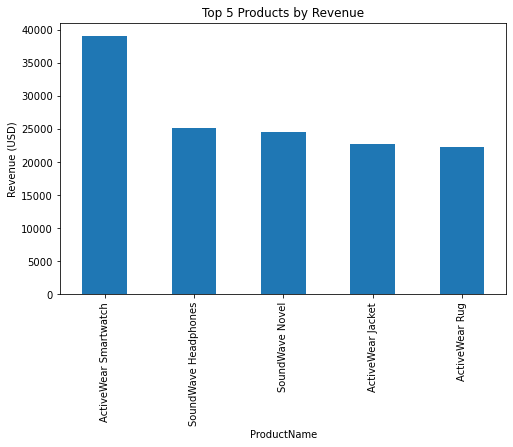

In [23]:
#Top 5 products by revenue
top_products = merged_data.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False).head(5)
top_products.plot(kind='bar', title='Top 5 Products by Revenue', figsize=(8, 5))
plt.ylabel('Revenue (USD)')
plt.show()



In [28]:
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
      'Price_x': 'mean'
}).reset_index()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop('CustomerID', axis=1))

similarity_matrix = cosine_similarity(scaled_features)

lookalikes = {}
for i, customer_id in enumerate(customer_features['CustomerID'][:20]):
    similar_indices = np.argsort(similarity_matrix[i])[::-1][1:4]
    similar_customers = [(customer_features.iloc[j]['CustomerID'], similarity_matrix[i][j]) for j in similar_indices]
    lookalikes[customer_id] = similar_customers


lookalike_df = pd.DataFrame([(k, v) for k, v in lookalikes.items()], columns=['CustomerID', 'Lookalikes'])
lookalike_df.to_csv('FirstName_LastName_Lookalike.csv', index=False)

In [30]:
# Combine customer and transaction data
segmentation_data = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price_x': 'mean'
}).reset_index()

segmentation_features = scaler.fit_transform(segmentation_data.drop('CustomerID', axis=1))
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(segmentation_features)
segmentation_data['Cluster'] = clusters


db_index = davies_bouldin_score(segmentation_features, clusters)
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 0.8381033044288836


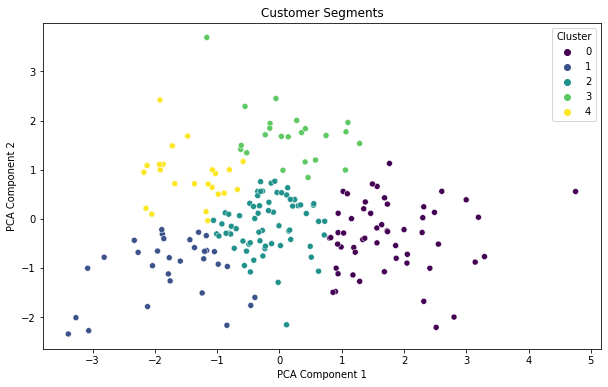

In [31]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(segmentation_features)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=segmentation_data['Cluster'], palette='viridis')
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

segmentation_data.to_csv('FirstName_LastName_Clustering.csv', index=False)
